# Image recognition using Neural Network

The following notebook is implemented a two-layer neural network for image recognition using Python.

The training set used is the MNIST dataset.

In [177]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Libraries
import numpy as np # Numpy library for numerical operations and linear algebra
import pandas as pd # Pandas library for data science tools and data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt  # Matplotlib library for MATLAB tools

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/data.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


### Read data

In [178]:
# Read data from data set
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

### Preview data

In [179]:
data.head

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

In [180]:
# Transform data to array
data = np.array(data)
# Get the number of rows 'm' and columns 'n'
m_original, n_original = data.shape

# Shuffle data before splitting
np.random.shuffle(data)

### Split data into test and training set

In [181]:
# Spit data from training and test
nTest = 1000

# Test set
data_test = data[0:nTest].T
Y_test = data_test[0]
X_test = data_test[1:n_original]
X_test = X_test / 255.

# Train set
data_train = data[nTest:m_original].T
Y_train = data_train[0]
X_train = data_train[1:n_original]
X_train = X_train / 255.
_,m_train = X_train.shape

# _,m_train = X_train.shape

# Y_train = Y_train / 255. # Normalize (to avoid exp overflow)

In [182]:
Y_train

array([0, 8, 0, ..., 9, 3, 7])

The NN will feature a straightforward two-layer design. The input layer $a[0]$ will have 784 units, which match to the 784 pixels in each 28x28 input picture. A hidden layer $a[1]$ will have 10 units with ReLU activation, and the output layer $a[2]$ will have 10 units with softmax activation corresponding to the ten digit classes.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

### Functions
Below are the list of functions that will be used

In [183]:
# Inititate parameters
def initateParameters():
    # Get arbitrary weights and biases
    # Substract 0.5 since randn generate values from 0 to 1
    W1 = np.random.rand(10, 784) - 0.5 # Matrix of 70 x 784
    b1 = np.random.rand(10, 1) - 0.5 # Vector of 10 x 1
    W2 = np.random.rand(10, 10) - 0.5 # Matrix of 10 x 10
    b2 = np.random.rand(10, 1) - 0.5 # Vector of 10 x 1
    return W1, b1, W2, b2

# ReLU activation function
def ReLU(Z):
    return np.maximum(Z, 0)
    
# ReLU derivative activation function
def ReLU_deriv(Z):
    return Z > 0

# Softmax activation function
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

# Sigmoid activation function
#def Sigmoid(Z):
#    S = 1 / (1 + np.exp(-Z))
#    return S

# Sigmoid derivative activation function
# def Sigmoid_deriv(Z):
#    S_deriv = Sigmoid(Z) * (1 - Sigmoid(Z))
#    return S_deriv

# Forward propagation
def forwardPropagation(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Complete Y data, return the activation
def oneHot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) # Since there are 0 - 9 numbers = 10
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# Backward propagation
def backwardPropagation(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = oneHot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m_original * dZ2.dot(A1.T)
    db2 = 1 / m_original * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m_original * dZ1.dot(X.T)
    db1 = 1 / m_original * np.sum(dZ1)
    return dW1, db1, dW2, db2

# Update parameters
def updateParameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [184]:
# Return prediction
def getPredictions(A2):
    return np.argmax(A2, 0) # Return the index of the maximum argunment, thus, the predicted number index of the [10 x 1] output vector

# Prediction accuracy
def getAccuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size # Accuracy of the predicted number

# Gradient descent function
def gradientDescent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = initateParameters()
    # Loop through the amount of iterations we set
    for i in range(iterations):
        Z1, A1, Z2, A2 = forwardPropagation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backwardPropagation(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = updateParameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        # For every iterations, print prediction
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = getPredictions(A2)
            print(getAccuracy(predictions, Y))
    return W1, b1, W2, b2

### Execute code

In [185]:
W1, b1, W2, b2 = gradientDescent(X_train, Y_train, 0.10, 1000)

Iteration:  0
[5 1 6 ... 3 1 5] [0 8 0 ... 9 3 7]
0.11492682926829269
Iteration:  100
[0 8 0 ... 7 3 3] [0 8 0 ... 9 3 7]
0.6178780487804878
Iteration:  200
[0 8 0 ... 9 3 7] [0 8 0 ... 9 3 7]
0.766609756097561
Iteration:  300
[0 8 0 ... 9 3 7] [0 8 0 ... 9 3 7]
0.8168048780487804
Iteration:  400
[0 8 0 ... 9 3 7] [0 8 0 ... 9 3 7]
0.8408048780487805
Iteration:  500
[0 8 0 ... 9 3 7] [0 8 0 ... 9 3 7]
0.8542195121951219
Iteration:  600
[0 8 0 ... 9 3 7] [0 8 0 ... 9 3 7]
0.8639756097560976
Iteration:  700
[0 8 0 ... 9 3 7] [0 8 0 ... 9 3 7]
0.8710731707317073
Iteration:  800
[0 8 0 ... 9 3 7] [0 8 0 ... 9 3 7]
0.8760731707317073
Iteration:  900
[0 8 0 ... 9 3 7] [0 8 0 ... 9 3 7]
0.8798536585365854


### Test an image

In [189]:
# To make a singular prediction with the weights and biases calculated
def makePredictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forwardPropagation(W1, b1, W2, b2, X)
    predictions = getPredictions(A2)
    return predictions

# Test prediction 
def testPredictions(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = makePredictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

### Check some examples of the train set

Prediction:  [0]
Label:  0


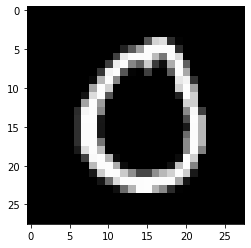

Prediction:  [6]
Label:  6


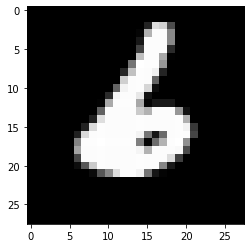

Prediction:  [4]
Label:  9


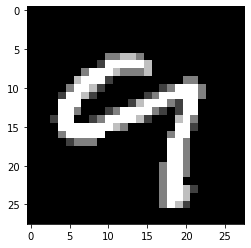

Prediction:  [9]
Label:  9


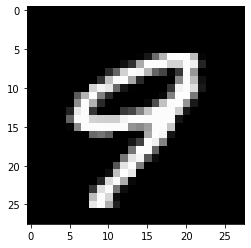

In [193]:
testPredictions(0, W1, b1, W2, b2)
testPredictions(1000, W1, b1, W2, b2)
testPredictions(40123, W1, b1, W2, b2)
testPredictions(40000, W1, b1, W2, b2)

### Check for the test set

In [188]:
test_set_predictions = makePredictions(X_test, W1, b1, W2, b2)
getAccuracy(test_set_predictions, Y_test)

[4 9 9 4 2 8 8 7 8 9 1 7 6 2 9 9 2 8 3 1 1 1 0 1 8 3 1 0 8 6 3 0 4 1 7 3 3
 0 2 6 0 3 3 8 7 9 7 6 5 0 6 5 4 8 3 3 7 5 0 4 0 3 1 6 7 9 1 9 1 6 6 0 1 5
 5 4 1 6 4 1 9 1 6 9 1 2 6 8 0 4 5 1 5 4 7 4 0 1 9 4 3 7 3 7 9 1 4 9 3 2 7
 2 7 4 5 7 6 5 9 2 2 7 6 9 4 8 4 5 3 7 4 3 9 4 9 7 5 9 2 0 9 0 9 0 3 4 2 0
 4 6 3 2 0 7 8 9 9 6 0 3 9 4 1 9 5 4 9 2 1 6 5 8 0 3 7 2 5 7 7 8 0 6 2 6 7
 6 6 3 9 7 4 1 2 1 6 7 4 1 3 7 3 7 6 0 8 6 7 3 6 6 9 8 8 8 7 3 6 1 3 2 1 1
 5 3 0 3 1 4 6 6 6 6 4 0 1 4 0 7 1 6 8 1 8 2 3 9 8 8 0 7 6 7 4 4 7 1 3 0 0
 9 9 3 0 5 4 2 4 1 1 6 2 6 8 5 2 4 0 0 2 3 8 0 2 6 0 6 1 0 7 3 3 8 0 2 3 2
 1 2 6 3 1 3 3 8 6 8 6 5 2 6 5 4 9 7 1 3 2 4 9 2 4 9 3 0 7 0 0 0 1 4 3 8 2
 9 4 1 1 5 9 7 0 7 5 1 3 1 7 5 7 0 9 5 1 8 3 9 5 4 7 5 0 0 7 7 9 6 0 6 1 7
 6 0 2 0 1 6 1 0 8 9 8 8 3 6 3 3 6 3 7 4 6 8 7 8 3 3 0 0 0 1 9 5 0 0 7 0 4
 6 9 2 9 8 5 8 2 1 5 0 8 2 2 1 0 8 3 2 9 5 1 4 3 4 5 1 4 5 9 1 3 6 1 1 2 8
 0 8 6 7 4 3 0 9 9 2 9 1 2 4 9 4 1 8 7 8 4 6 9 1 9 1 6 4 1 3 3 3 4 6 5 2 3
 7 9 9 8 1 3 2 3 3 7 3 8 

0.881